In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data_fns import load_mnist
from estimator import classical_weights, V1_inspired_weights
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pickle

In [2]:
# load data
train, train_labels, test, test_labels = load_mnist()
X_train, y_train = torch.from_numpy(train).float(), torch.from_numpy(train_labels).long()
X_test, y_test = torch.from_numpy(test).float(), torch.from_numpy(test_labels).long()
train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
n, d = X_train.shape

In [3]:
# define models
class V1_net(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(d, hidden_size)
        self.fc1.weight.data = torch.FloatTensor(V1_inspired_weights(hidden_size, d, t=5, l=2, scale=1))
        self.output = nn.Linear(hidden_size, 10)
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return self.output(x)
    
class RF_net(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(d, hidden_size)
        self.fc1.weight.data = torch.FloatTensor(classical_weights(hidden_size, d, scale=1))
        self.output = nn.Linear(hidden_size, 10)
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return self.output(x)
    
def predict(model, X):
    return model(X).data.max(1)[1]

def error(model, X, y):
    y_pred = predict(model, X)
    accuracy = 1.0 * torch.sum(y_pred == y) / len(y)
    return 1 - accuracy

In [5]:
h, lr = 50, 1e-2
loss_func = nn.CrossEntropyLoss()
n_epochs, n_trials = 10, 3
t, l = 5, 3

models = {'V1': V1_net, 'RF': RF_net}
train_err = {m: np.zeros((n_trials, n_epochs)) for m in models.keys()}
test_err = {m: np.zeros((n_trials, n_epochs)) for m in models.keys()}
loss_list = {m: np.zeros((n_trials, n_epochs)) for m in models.keys()}

for m, network in models.items():
    for i in range(n_trials):
        model = network(h)
        optim = torch.optim.SGD(model.parameters(), lr=lr)
        for j in range(n_epochs):
            for x_batch, y_batch in train_loader:
                optim.zero_grad()
                loss = loss_func(model(x_batch), y_batch)
                loss.backward()
                optim.step()

            train_err[m][i, j] = error(model, X_train, y_train)
            test_err[m][i, j] = error(model, X_test, y_test)
            loss_list[m][i, j] = loss_func(model(X_train), y_train)
        
            print('Trial %d, Epoch: %d, %s model Loss=%0.3f, test err=%0.3f' % (i, j, m, loss_list[m][i, j], 
                                                                                test_err[m][i, j]))
            
# results = {'test_err': test_err, 'train_err': train_err, 'loss': loss_list}
# with open('results/initialize_mnist/clf_SGD_t=%0.2f_l=%0.2f_h=%d_lr=%0.4f.pickle' % (t, l, h, lr), 'wb') as handle:
#     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Trial 0, Epoch: 0, V1 model Loss=0.444, test err=0.102
Trial 0, Epoch: 1, V1 model Loss=0.362, test err=0.094
Trial 0, Epoch: 2, V1 model Loss=0.264, test err=0.075
Trial 0, Epoch: 3, V1 model Loss=0.227, test err=0.069
Trial 0, Epoch: 4, V1 model Loss=0.207, test err=0.067
Trial 0, Epoch: 5, V1 model Loss=0.185, test err=0.056
Trial 0, Epoch: 6, V1 model Loss=0.227, test err=0.076
Trial 0, Epoch: 7, V1 model Loss=0.183, test err=0.062
Trial 0, Epoch: 8, V1 model Loss=0.165, test err=0.055
Trial 0, Epoch: 9, V1 model Loss=0.168, test err=0.058
Trial 1, Epoch: 0, V1 model Loss=0.479, test err=0.107
Trial 1, Epoch: 1, V1 model Loss=0.358, test err=0.087
Trial 1, Epoch: 2, V1 model Loss=0.301, test err=0.076
Trial 1, Epoch: 3, V1 model Loss=0.264, test err=0.081
Trial 1, Epoch: 4, V1 model Loss=0.201, test err=0.060
Trial 1, Epoch: 5, V1 model Loss=0.190, test err=0.058
Trial 1, Epoch: 6, V1 model Loss=0.185, test err=0.058
Trial 1, Epoch: 7, V1 model Loss=0.173, test err=0.056
Trial 1, E

KeyboardInterrupt: 

In [ ]:
avg_train_err = {m: np.mean(train_err[m], axis=0) for m in train_err.keys()}
avg_test_err = {m: np.mean(test_err[m], axis=0) for m in test_err.keys()}
avg_loss_list = {m: np.mean(loss_list[m], axis=0) for m in loss_list.keys()}

std_train_err = {m: np.std(train_err[m], axis=0) for m in train_err.keys()}
std_test_err = {m: np.std(test_err[m], axis=0) for m in test_err.keys()}
std_loss_list = {m: np.std(loss_list[m], axis=0) for m in loss_list.keys()}

fig = plt.figure(figsize=(12, 5))
plt.suptitle(r'Shallow FFW FC net w/ SGD. h=%d, E$\|w\|$=%0.2f, lr=%0.4f, '%(h, w, lr), fontsize=16)
ax = fig.add_subplot(131)
plt.title('Network loss', fontsize=16)
plt.plot(np.arange(n_epochs), avg_loss_list['V1'], label='V1-inspired', lw=3)
plt.plot(np.arange(n_epochs), avg_loss_list['RF'], label='classical', lw=3)
plt.fill_between(np.arange(n_epochs), avg_loss_list['V1'] - std_loss_list['V1'], 
                 avg_loss_list['V1'] + std_loss_list['V1'], alpha=0.2)
plt.fill_between(np.arange(n_epochs), avg_loss_list['RF'] - std_loss_list['RF'], 
                 avg_loss_list['RF'] + std_loss_list['RF'], alpha=0.2)



plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Training loss', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14, width=2, length=6)
plt.legend(fontsize=18)

ax = fig.add_subplot(132)
plt.title('Train error', fontsize=16)
plt.plot(np.arange(n_epochs), avg_train_err['V1'], label='V1-inspired', lw=3)
plt.plot(np.arange(n_epochs), avg_train_err['RF'],  label='classical', lw=3)
plt.fill_between(np.arange(n_epochs), avg_train_err['V1'] - std_train_err['V1'], 
                 avg_train_err['V1'] + std_train_err['V1'],  alpha=0.2 )
plt.fill_between(np.arange(n_epochs), avg_train_err['RF'] - std_train_err['RF'], 
                 avg_train_err['RF'] + std_train_err['RF'],  alpha=0.2 )
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Training error', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14, width=2, length=6)
plt.yticks(np.arange(0, 1, 0.2))
plt.legend(fontsize=18)

ax = fig.add_subplot(133)
plt.title('Test error', fontsize=16)
plt.plot(np.arange(n_epochs), avg_test_err['V1'], label='V1-inspired', lw=3)
plt.plot(np.arange(n_epochs), avg_test_err['RF'], label='classical', lw=3)
plt.fill_between(np.arange(n_epochs), avg_test_err['V1'] - std_test_err['V1'], 
                 avg_test_err['V1'] + std_test_err['V1'], alpha=0.2 )
plt.fill_between(np.arange(n_epochs), avg_test_err['RF'] - std_test_err['RF'], 
                 avg_test_err['RF'] + std_test_err['RF'], alpha=0.2 )
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Test error', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14, width=2, length=6)
plt.yticks(np.arange(0, 1, 0.2))
plt.legend(fontsize=18)
                                       
plt.tight_layout()
plt.subplots_adjust(top=0.8)
# plt.savefig('results/initialize_mnist/init_h=%d_lr=%0.3f_SGD.png'%(h, lr))

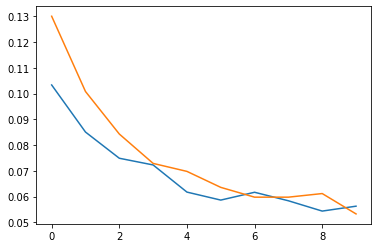

In [12]:
fig = plt.figure()
plt.plot(np.mean(test_err['V1'], axis=0))
plt.plot(test_err['RF'][0])